In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atm-data/final_atm_data.csv
/kaggle/input/atm-data/merged_df.csv
/kaggle/input/atm-data/culster_data1_b.csv
/kaggle/input/atm-data/culster_data2_b.csv
/kaggle/input/atm-data/culster_data0_b.csv
/kaggle/input/atm-data/merged_atm_data.csv
/kaggle/input/atm-data/final_data_cleaned_ready.csv
/kaggle/input/atm-data/data_after_holiday_features.csv


In [3]:
df = pd.read_csv('/kaggle/input/atm-data/final_atm_data.csv')

In [4]:
print(list(df.columns))

['date', 'atm_id', 'amount', 'CITY_CODE', 'region', 'day_off_discription', 'dayofyear', 'sin_day', 'cos_day', 'day_of_week', 'day_of_month', 'month_of_year', 'week_of_year', 'is_end_of_month', 'is_start_of_month', 'days_until_month_end', 'weekend_type', 'is_holiday', 'days_after_last_holiday', 'zone_type', 'AidAdha_D-15', 'AidAdha_D-14', 'AidAdha_D-13', 'AidAdha_D-12', 'AidAdha_D-11', 'AidAdha_D-10', 'AidAdha_D-9', 'AidAdha_D-8', 'AidAdha_D-7', 'AidAdha_D-6', 'AidAdha_D-5', 'AidAdha_D-4', 'AidAdha_D-3', 'AidAdha_D-2', 'AidAdha_D-1', 'AidAdha_day', 'AidAdha_D1', 'AidAdha_D2', 'AidAdha_D3', 'AidAdha_D4', 'AidAdha_D5', 'AidAdha_D6', 'AidAdha_D7', 'AidAdha_D8', 'AidAdha_D9', 'AidAdha_D10', 'AidFitr_D-7', 'AidFitr_D-6', 'AidFitr_D-5', 'AidFitr_D-4', 'AidFitr_D-3', 'AidFitr_D-2', 'AidFitr_D-1', 'AidFitr_day', 'AidFitr_D1', 'AidFitr_D2', 'AidFitr_D3', 'Mawlid_D-2', 'Mawlid_D-1', 'Mawlid_day', 'Mawlid_D1', 'Mawlid_D2', 'Hijri_D-1', 'Hijri_day', 'Hijri_D1', 'FeteTravail_D-1', 'FeteTravail_day',

In [5]:
df.dtypes

date                      object
atm_id                     int64
amount                   float64
CITY_CODE                  int64
region                     int64
                          ...   
rolling_max_gap          float64
rolling_min_gap          float64
days_since_last_spike    float64
avg_by_dow               float64
lag_corr_7               float64
Length: 126, dtype: object

In [6]:
df['date']=pd.to_datetime(df['date'])

In [7]:
df=df.set_index('date')

In [8]:
df['amount_next_day'] = df.groupby('atm_id')['amount'].shift(-1)

In [9]:
df[['amount_next_day','amount']]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,amount_next_day,amount
date,,
2022-01-01,16000.00,37300.00
2022-01-02,84000.00,16000.00
2022-01-03,55556.77,84000.00
2022-01-04,74373.69,55556.77
2022-01-05,43200.00,74373.69
...,...,...
2025-01-17,600.00,3600.00
2025-01-18,300.00,600.00
2025-01-19,1100.00,300.00


In [10]:
df=df.dropna()

In [11]:
X=df.drop(columns=['amount_next_day'])
Y=df['amount_next_day']

In [12]:
X = X.sort_index()
Y = Y.sort_index()
train_start, train_end = "2022-01-01", "2024-11-30"
test_start, test_end = "2024-12-01", "2025-1-21"

X_train = X.loc[train_start:train_end]
y_train = Y.loc[train_start:train_end]
X_test = X.loc[test_start:test_end]
y_test = Y.loc[test_start:test_end]

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import xgboost as xgb


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
mae_scores, rmse_scores, r2_scores = [], [], []

model = xgb.XGBRegressor()


for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    y_val_pred = model.predict(X_val_fold)

    mae = mean_absolute_error(y_val_fold, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    r2 = r2_score(y_val_fold, y_val_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.2f}")


model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred = model.predict(X_test)


final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print("\nFinal Test Set Performance (2024):")
print(f"MAE: {final_mae:.2f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"R²: {final_r2:.2f}")



Average MAE: 39850.20
Average RMSE: 62922.90
Average R²: 0.74

Final Test Set Performance (2024):
MAE: 37615.99
RMSE: 58295.18
R²: 0.78


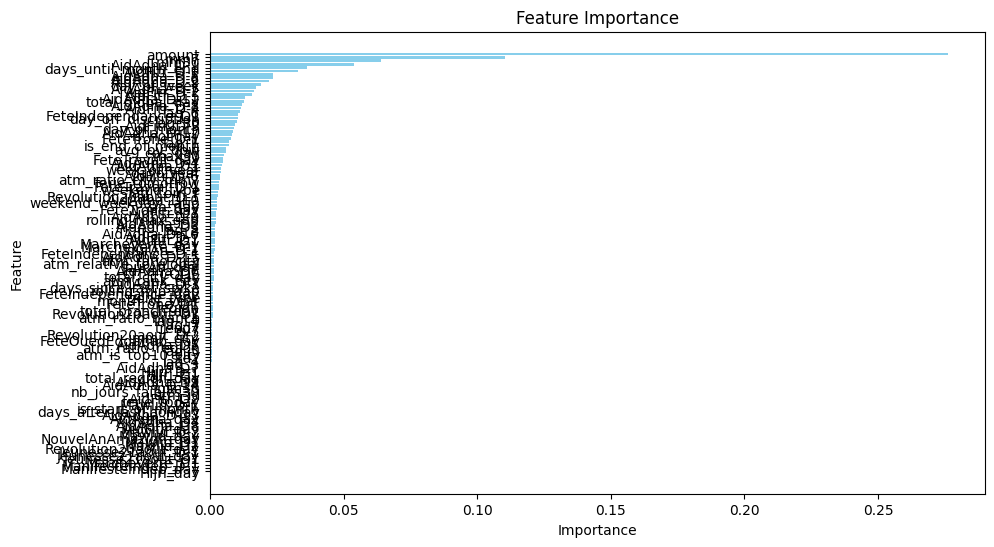

In [14]:
import matplotlib.pyplot as plt 
feature_importance = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()


In [18]:
len(list(df.columns))

126

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

# 1. Train initial model to extract feature importance
initial_model = xgb.XGBRegressor()
initial_model.fit(X_train, y_train)

# 2. Get non-zero importance features
importance_df = pd.Series(initial_model.feature_importances_, index=X_train.columns)
non_zero_features = importance_df[importance_df > 0].index.tolist()

print(f"✅ Selected {len(non_zero_features)} features with non-zero importance.\n")

# 3. Combine all data
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])
X_all_filtered = X_all[non_zero_features]

# 4. Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
r2_scores = []

fold = 1
for train_idx, test_idx in tscv.split(X_all_filtered):
    X_t, X_v = X_all_filtered.iloc[train_idx], X_all_filtered.iloc[test_idx]
    y_t, y_v = y_all.iloc[train_idx], y_all.iloc[test_idx]

    model = xgb.XGBRegressor()
    model.fit(X_t, y_t)

    y_pred = model.predict(X_v)

    mae = mean_absolute_error(y_v, y_pred)
    rmse = mean_squared_error(y_v, y_pred, squared=False)
    r2 = r2_score(y_v, y_pred)

    print(f"Fold {fold}:")
    print(f"  • MAE : {mae:.2f}")
    print(f"  • RMSE: {rmse:.2f}")
    print(f"  • R²  : {r2:.4f}\n")

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    fold += 1

# 5. Summary of cross-validation
print("✅ Cross-validation summary with non-zero importance features:")
print(f"  • Avg MAE : {np.mean(mae_scores):.2f}")
print(f"  • Avg RMSE: {np.mean(rmse_scores):.2f}")
print(f"  • Avg R²  : {np.mean(r2_scores):.4f}")


✅ Selected 103 features with non-zero importance.

Fold 1:
  • MAE : 46756.87
  • RMSE: 66862.97
  • R²  : 0.6848

Fold 2:
  • MAE : 42604.00
  • RMSE: 71812.70
  • R²  : 0.6672

Fold 3:
  • MAE : 36164.61
  • RMSE: 57004.37
  • R²  : 0.7686

Fold 4:
  • MAE : 40572.20
  • RMSE: 63827.19
  • R²  : 0.7509

Fold 5:
  • MAE : 38992.29
  • RMSE: 60410.63
  • R²  : 0.7692

✅ Cross-validation summary with non-zero importance features:
  • Avg MAE : 41017.99
  • Avg RMSE: 63983.57
  • Avg R²  : 0.7281


In [21]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data (already filtered and sorted)
X = df.drop(columns=['amount_next_day'])
y = df['amount_next_day']
X_numeric = X.select_dtypes(include='number')  # CatBoost handles categoricals, but for simplicity, use numerics

tscv = TimeSeriesSplit(n_splits=5)

rmse_list = []
mae_list = []
r2_list = []

fold = 1
for train_index, test_index in tscv.split(X_numeric):
    X_train, X_test = X_numeric.iloc[train_index], X_numeric.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor(loss_function='MAE', random_seed=42, verbose=0)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"Fold {fold}")
    print(f"[TRAIN] • RMSE: {mean_squared_error(y_train, y_pred_train, squared=False):.2f} • MAE: {mean_absolute_error(y_train, y_pred_train):.2f} • R²: {r2_score(y_train, y_pred_train):.4f}")
    print(f"[TEST]  • RMSE: {rmse:.2f} • MAE: {mae:.2f} • R²: {r2:.4f}")
    print("-" * 60)

    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    fold += 1

# Summary of cross-validation
print("✅ Cross-validation summary:")
print(f"   • Avg RMSE: {np.mean(rmse_list):.2f}")
print(f"   • Avg MAE : {np.mean(mae_list):.2f}")
print(f"   • Avg R²  : {np.mean(r2_list):.4f}")


Fold 1
[TRAIN] • RMSE: 55472.66 • MAE: 34792.86 • R²: 0.7679
[TEST]  • RMSE: 57803.06 • MAE: 36547.53 • R²: 0.7653
------------------------------------------------------------
Fold 2
[TRAIN] • RMSE: 56139.65 • MAE: 35323.36 • R²: 0.7709
[TEST]  • RMSE: 56508.31 • MAE: 35379.29 • R²: 0.8014
------------------------------------------------------------
Fold 3
[TRAIN] • RMSE: 56303.10 • MAE: 35374.68 • R²: 0.7819
[TEST]  • RMSE: 56430.76 • MAE: 34720.75 • R²: 0.7916
------------------------------------------------------------
Fold 4
[TRAIN] • RMSE: 56313.42 • MAE: 35190.36 • R²: 0.7847
[TEST]  • RMSE: 57717.42 • MAE: 35646.14 • R²: 0.7839
------------------------------------------------------------
Fold 5
[TRAIN] • RMSE: 56526.91 • MAE: 35270.81 • R²: 0.7851
[TEST]  • RMSE: 49158.26 • MAE: 29649.06 • R²: 0.8287
------------------------------------------------------------
✅ Cross-validation summary:
   • Avg RMSE: 55523.56
   • Avg MAE : 34388.55
   • Avg R²  : 0.7942


Selected random ATMs: [2270 2488 2059]


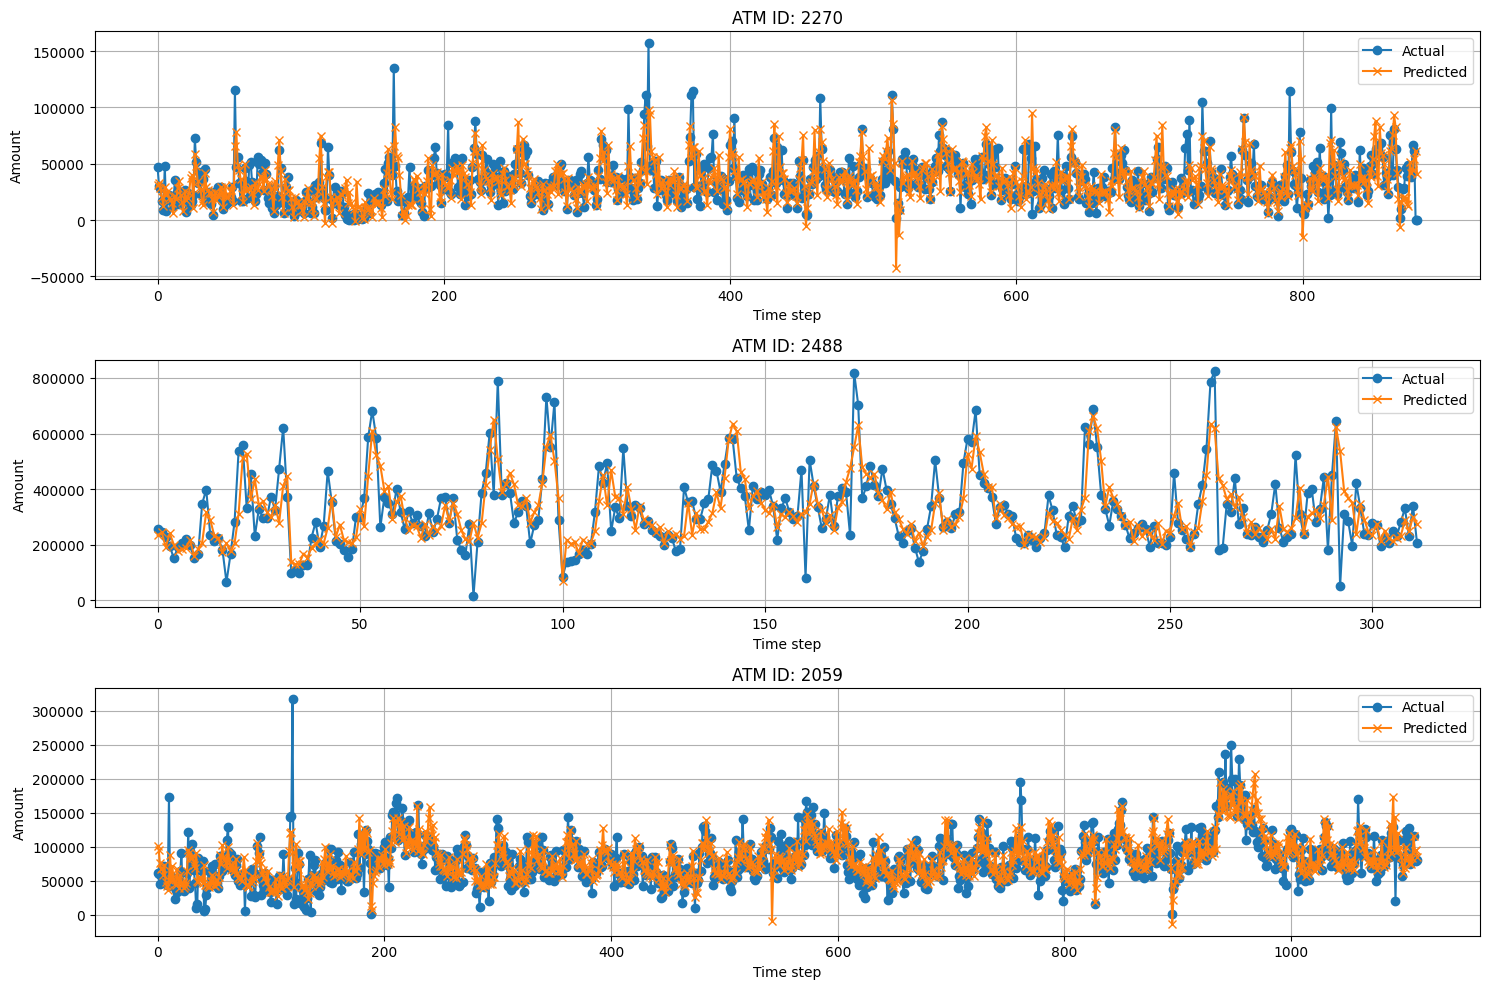

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Ensure predictions exist
y_pred = model.predict(X_test)

# Ensure 'atm_id' in X_test
assert 'atm_id' in X_test.columns, "'atm_id' must be in X_test"

# Create DataFrame with results
df_results = X_test.copy()
df_results['y_true'] = y_test.values
df_results['y_pred'] = y_pred

# Get unique ATM ids
unique_atms = df_results['atm_id'].unique()

# Select 3 random ATMs
np.random.seed(42)  # For reproducibility
random_atms = np.random.choice(unique_atms, size=3, replace=False)

print(f"Selected random ATMs: {random_atms}")

# Plot each ATM's actual vs predicted
plt.figure(figsize=(15, 10))

for i, atm_id in enumerate(random_atms, 1):
    atm_data = df_results[df_results['atm_id'] == atm_id]
    
    plt.subplot(3, 1, i)
    plt.plot(atm_data['y_true'].values, label='Actual', marker='o')
    plt.plot(atm_data['y_pred'].values, label='Predicted', marker='x')
    plt.title(f"ATM ID: {atm_id}")
    plt.xlabel("Time step")
    plt.ylabel("Amount")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
